<h1> Predicting Airbnb Price in European Cities </h1>

**Group 15** <br>
Mathew <br>
Marcus <br>
Zahra <br>
Alizah <br>

# Introduction

TODO: (condense description of Airbnb to maybe 2-3 ish sentences + 1 for importance)

Nowadays, the role of the sharing economy in tourism is increasing, and the number of people involved as guests or hosts is rising day by day. This dynamic generates a viable alternative to the traditional services, allowing tourists to customize their trips and enrich their experiences.

Airbnb began as a way for travellers to find unique, local experiences and accommodations, and for hosts to earn extra income by renting out spare rooms, apartments, or entire homes. Over time, it has expanded to include a wide range of options—from urban apartments and rural cabins to luxury villas and even treehouses—offering travellers diverse ways to stay and explore around the world.
Airbnb operates on a sharing economy model, where hosts can monetize their property by listing it on the platform. The platform is accessible via the Airbnb website or mobile app, enabling both hosts and guests to manage bookings, communicate, and leave reviews.

### Data Description
Our analysis will use the dataset [Airbnb Prices in European Cities](https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities/data), sourced from kaggle.

This dataset contains detailed Airbnb listing information from several major European cities. We will focus on London, Rome, and Budapest, for a total of 23,042 observations. 

(It includes attributes such as room type, host status, guest satisfaction, number of bedrooms, and geographic data (distance from city center, latitude, and longitude), enabling spatial econometric analysis of weekday and weekend pricing. )

The data appears to be aggregated from Airbnb listings and reviews, (reflecting both social and geographical influences on rental pricing strategies.)

There are 20 variables in the original dataset, however, one is the `id` column which is the same as the row number, and four others (`attr_index`, `attr_index_norm`, `rest_index`, `rest_index_norm`) are not explained in detail. This leaves us with 15 variables, detailed below:

| Column name   | Description   | Data Type     |
| ------------- | ------------- | ------------- |
| `realSum` | The total price of the Airbnb listing (Euros). | Numeric |
| `room_type` | The type of room being offered (e.g. private, shared, etc.). | Categorical |
| `room_shared` | Whether the room is shared or not. | Boolean |
| `room_private` | Whether the room is private or not. | Boolean |
| `person_capacity` | The maximum number of people that can stay in the room. | Numeric |
| `host_is_superhost` | Whether the host is a superhost or not. | Boolean |
| `multi` | Whether the listing is for multiple rooms or not. | Boolean |
| `biz` | Whether the listing is for business purposes or not. | Boolean |
| `cleanliness_rating` | The cleanliness rating of the listing. | Numeric |
| `guest_satisfaction_overall` | The overall guest satisfaction rating of the listing. | Numeric |
| `bedrooms` | The number of bedrooms in the listing. | Numeric |
| `dist` | The distance from the city centre. | Numeric |
| `metro_dist` | The distance from the nearest metro station. | Numeric |
| `lng` | The longitude of the listing. | Numeric |
| `lat` | The latitude of the listing. | Numeric |


In addition, we add the following two variables as a result of merging the data, for a total of 17 variables: 

| Column name   | Description   | Data Type     |
| ------------- | ------------- | ------------- |
| `city` | The city location of the Airbnb listing. | Categorical |
| `isWeekend` | Whether the listing is for weekends or not. | Boolean |

From the above, we will drop `lng` and `lat`, because they must be considered in a grouped and discrete manner to be meaningful, and may also be collinear with `dist`, `metro_dist` and `city`. 

We want to know what the key determinants of the price of an Airbnb listing are, as this is a question of importance from both perspectives: listing a place as a host, or from the point of view of a guest looking for an accommodation. An accurate assessment of Airbnb price determinants is essential not only for tourism management but also for urban planning. Previous studies on Airbnb listings have shown that size, quality, and host reputation play a significant role, along with the location of the Airbnb.

### **Our Question:** Which factors are most useful for predicting the price of an Airbnb listing?

Until now, different studies have been focussed on price determinants of Airbnb listings, their results emphasising the complexity of the relationship between pricing and its determinants. Moreover, different authors suggest that the relationship between price and its determinants differ undoubtedly across cities/countries/regions due to the variation in city types, city economics, and Airbnb development in the region.

** Literature portion**

** ADD IN LINK TO LITERATURE WITH IN TEXT CITATIONS **

# Methods and Results

## a) Exploratory Data Analysis
To begin our analysis, we start by reading our data, with modfications to keep it tidy.

In [2]:
# install.packages("mltools")
# install.packages("glmnet")
# install.packages("leaps")

In [3]:
# Libraries & Packages
library(tidyverse)
library(dplyr)
library(mltools)
library(rsample)
library(MASS)
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


ERROR: Error in library(mltools): there is no package called ‘mltools’


In [4]:
# Main developer: Alizah
# Contributor: Marcus (modified read function)

# Function to format & read data: 
# select vars from dataset and add city name + if it's weekend data
tidy_data <- function(path, cityName, isWeekend) {
    data <- read_csv(path, show_col_types = FALSE) %>%
            dplyr::select(-...1, -attr_index, -attr_index_norm, -rest_index, -rest_index_norm, -lng,-lat)
    data$room_type <- as.factor(data$room_type)
    data$city <- as.factor(cityName)
    data$isWeekend <- as.logical(isWeekend)
    return(data)
}

# Import and format data with tidy_data()
london_weekdays <- tidy_data("data/london_weekdays.csv", "London", 0)
london_weekends <- tidy_data("data/london_weekends.csv", "London", 1)
rome_weekdays <- (tidy_data("data/rome_weekdays.csv", "Rome", 0))
rome_weekends <- (tidy_data("data/rome_weekends.csv", "Rome", 1))
budapest_weekdays <- (tidy_data("data/budapest_weekdays.csv", "Budapest", 0))
budapest_weekends <- (tidy_data("data/budapest_weekends.csv", "Budapest", 1))

# Merge all the data together
data <- rbind(london_weekdays, london_weekends, rome_weekdays, rome_weekends, budapest_weekdays, budapest_weekends)

# View the head and tail of the data
head(data, 3)
tail(data, 3)

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,city,isWeekend
<dbl>,<fct>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
570.0981,Entire home/apt,FALSE,FALSE,2,FALSE,0,0,10,98,1,5.301018,1.5889904,London,FALSE
297.9844,Private room,FALSE,TRUE,2,TRUE,1,0,10,99,1,2.198946,0.3792620,London,FALSE
336.7906,Private room,FALSE,TRUE,2,FALSE,1,0,10,96,1,2.322958,0.4531776,London,FALSE


realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,city,isWeekend
<dbl>,<fct>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
162.8519,Entire home/apt,FALSE,FALSE,4,FALSE,0,0,10,93,1,11.855169,7.9301629,Budapest,TRUE
129.2475,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,10,90,1,1.669951,0.2725486,Budapest,TRUE
129.2475,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,10,93,1,1.669965,0.2725244,Budapest,TRUE


In [5]:
# Main developer: Matthew

data <- data %>%
    mutate(   #change columns into correct object types
            across(c(room_type,city),as.factor),
            across(c(multi,biz,isWeekend),as.logical)
        )

The data now appears to be in a tidy format.

Let's go through an EDA checklist:
- Packaging (& Wrangling as needed)
- Head and tail of data (presented in a tidy format)
- Check for NA values
- Check n's and summary statistics
- Plot visualizations for variables of interest

In [6]:
# Main developer: Marcus

# Packaging
str(data)

# Check for missing/NA values
anyNA(data)

# Compute summary statistics & check numbers
dim(data)
summary(data)

tibble [23,042 × 15] (S3: tbl_df/tbl/data.frame)
 $ realSum                   : num [1:23042] 570 298 337 227 256 ...
 $ room_type                 : Factor w/ 3 levels "Entire home/apt",..: 1 2 2 2 2 2 2 2 2 1 ...
 $ room_shared               : logi [1:23042] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ room_private              : logi [1:23042] FALSE TRUE TRUE TRUE TRUE TRUE ...
 $ person_capacity           : num [1:23042] 2 2 2 2 3 2 2 2 4 3 ...
 $ host_is_superhost         : logi [1:23042] FALSE TRUE FALSE TRUE FALSE FALSE ...
 $ multi                     : logi [1:23042] FALSE TRUE TRUE TRUE FALSE FALSE ...
 $ biz                       : logi [1:23042] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ cleanliness_rating        : num [1:23042] 10 10 10 10 9 10 10 10 9 8 ...
 $ guest_satisfaction_overall: num [1:23042] 98 99 96 99 98 100 100 95 93 74 ...
 $ bedrooms                  : num [1:23042] 1 1 1 1 1 1 1 1 1 0 ...
 $ dist                      : num [1:23042] 5.3 2.2 2.32 5.71 3.26 ...

[1] FALSE

[1] 23042    15

    realSum                   room_type     room_shared     room_private   
 Min.   :   34.78   Entire home/apt:13534   Mode :logical   Mode :logical  
 1st Qu.:  144.05   Private room   : 9432   FALSE:22966     FALSE:13610    
 Median :  195.92   Shared room    :   76   TRUE :76        TRUE :9432     
 Mean   :  268.47                                                          
 3rd Qu.:  296.57                                                          
 Max.   :15499.89                                                          
 person_capacity host_is_superhost   multi            biz         
 Min.   :2.000   Mode :logical     Mode :logical   Mode :logical  
 1st Qu.:2.000   FALSE:16996       FALSE:15590     FALSE:14747    
 Median :3.000   TRUE :6046        TRUE :7452      TRUE :8295     
 Mean   :3.168                                                    
 3rd Qu.:4.000                                                    
 Max.   :6.000                                                    

From the above summary statistics, we note the presence of outliers in `realSum` with a max of `15499.89`, which is much higher than the mean of `268.47`. 

A histogram of `realSum` will help visualize the distribution of our response and to remove outliers, to better understand possible relationships between `realSum` and the predictors.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


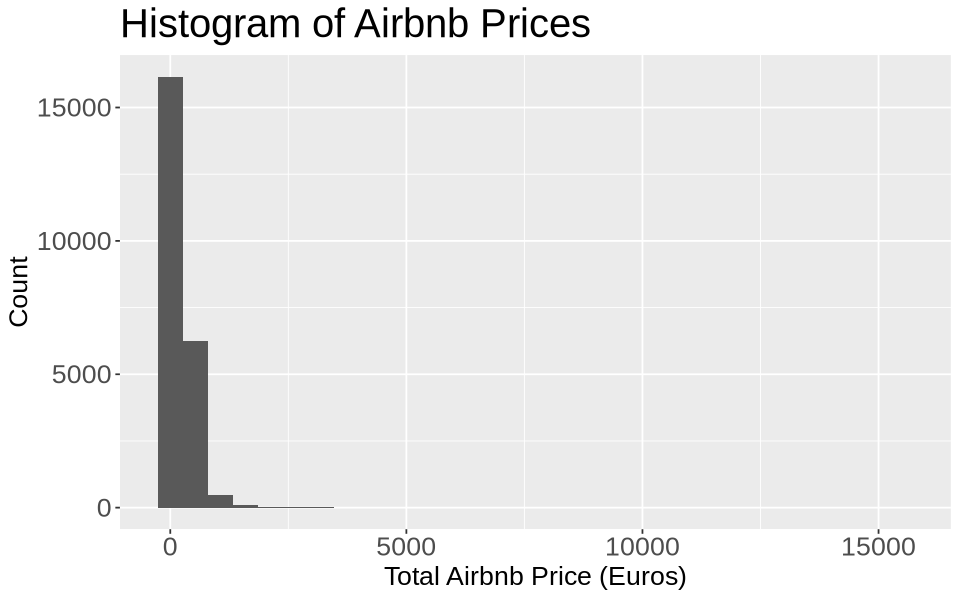

In [7]:
# Main developer: Marcus

# Plot a histogram of our response
options(repr.plot.width = 8, repr.plot.height = 5)

realSum_hist <- data %>%
    ggplot(aes(x=realSum)) +
    geom_histogram() +
    labs(title="Histogram of Airbnb Prices", x="Total Airbnb Price (Euros)", y="Count") +
    theme(axis.text = element_text(size = 16), 
          axis.title = element_text(size = 16),
         title=element_text(size = 20))

realSum_hist

Above, we clearly have large outliers in `realSum`. Let's filter the data to only contain the 95th percentile of `realSum`, stratified by city, and plot the histogram again, and this time include the mean. 

In [8]:
# Main developer: Marcus
# Contributor: Matthew (filtering)

# filtering outliers from each city by removing listing with prices that lies at the upper 5%
data_filt <- data %>% 
    group_by(city) %>%
    filter(realSum <= quantile(realSum, 0.95, na.rm = TRUE)) %>%
    ungroup()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


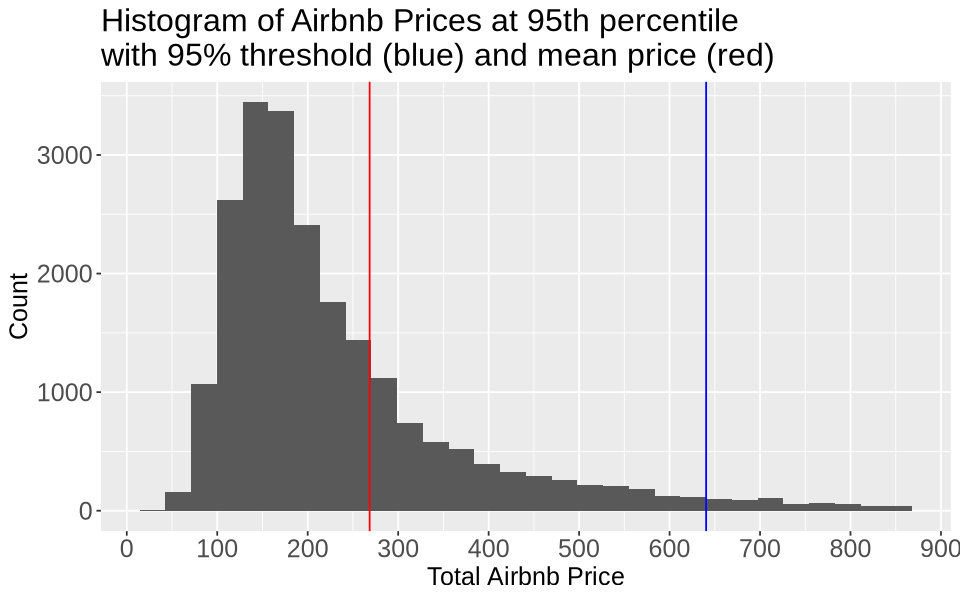

In [9]:
# Main developer: Marcus

realSum_hist_filt <- data_filt %>%
    ggplot(aes(x=realSum)) +
    geom_histogram() +
    geom_vline(xintercept=mean(data$realSum), color = "red") +
    geom_vline(xintercept=quantile(data$realSum, 0.95), color = "blue") +
    scale_x_continuous(breaks=seq(0, 1000, 100)) +
    ggtitle("Histogram of Airbnb Prices at 95th percentile\nwith 95% threshold (blue) and mean price (red)") +
    labs(x="Total Airbnb Price", y="Count") +
    theme(axis.text = element_text(size = 15), 
          axis.title = element_text(size = 15),
         title=element_text(size = 16))
    
realSum_hist_filt

It appears that our response data is very right skewed. 95% of Airbnb price listngs fall below about `900` when stratified by city, and fall below about `640` overal. The average price for all cities is about `280`. There also appears to be outliers at very low Airbnb price, so let's filter those, and then examine how the price varies per city.

In [10]:
# Main developer: Marcus

# Filter again to exclude lower 5%
data_filt <- data_filt %>%
    group_by(city) %>%
    filter(realSum >= quantile(realSum, 0.05, na.rm = TRUE)) %>%
    ungroup()

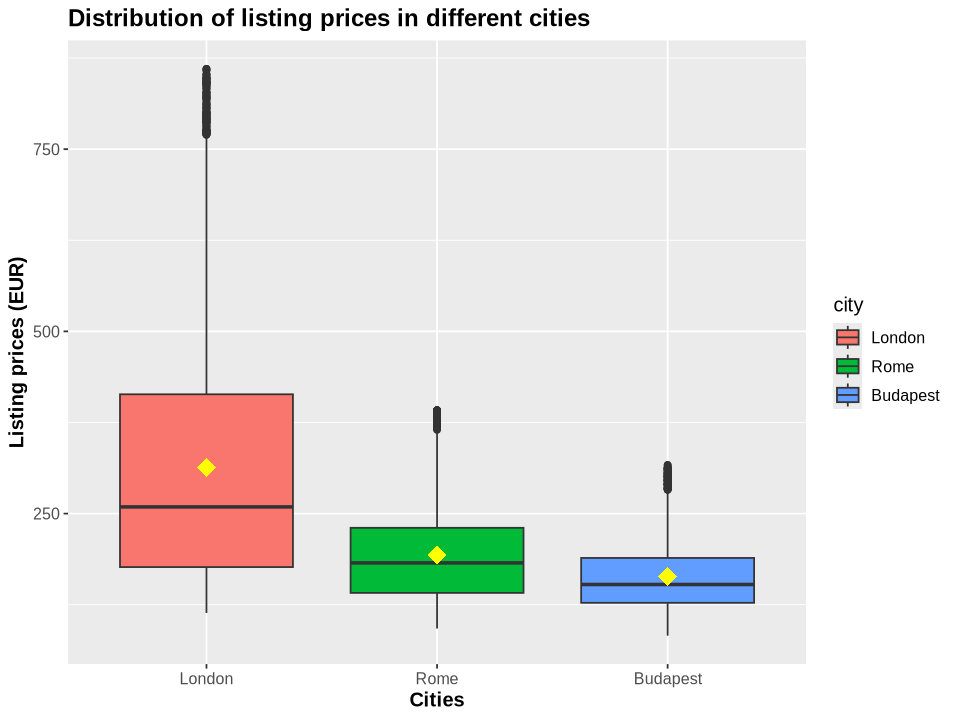

In [11]:
# Main developer: Matthew

options(repr.plot.height = 6, repr.plot.width = 8)

#To examine the distribution of listing prices in different cities through a boxplot
city_listing_plot <-
    data_filt %>%
    ggplot() +
    geom_boxplot(aes(x=city,y=realSum,fill=city))+
    ggtitle("Distribution of listing prices in different cities")+
    xlab("Cities")+
    ylab("Listing prices (EUR)")+
    stat_summary(aes(x=city, y=realSum),
        fun = mean, geom = "point", colour = "yellow", 
        shape = 18, size = 5
    ) +
    theme(
        text = element_text(size = 12),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )
city_listing_plot

The box plot above that shows the distribution of listing prices across Budapest, London and Rome, it helps with the question as it allows one to see how the listing prices varies between cities.

Starting with Budapest, it has the smallest variability in its distribution as well as the lowest median and mean. London, has the largest variability in its distribution and higher median and mean. Lastly, Rome has a variability in its distribution of listing prices thats relatively larger than Budapest as well a larger median and mean than Budapest but lower than London.

Budapest and Rome shares a relatively similar distribution, median and mean of listing prices to one another, but London's wider distribution and higher median and mean may affect the goodness of fit of the model.


## b) Analysis Plan

Since we are analyzing a prediction question, it's important that we separate the data into testing and training sets to prevent double-dipping and to get an accurate understanding of the our model's scalability. The rsample package will help us for this task. We will use initial_split() to randomly split our dataset, with 80% for training use. We will use the training() and testing() functions to extract the training and testing data respectively. 

#### Training: 
We will only use the training dataset here. We have 16 variables in our dataset that could be possible predictors of Airbnb listing price. We can use statistical variable selection process to determine which factors may be most useful in predicting our response. We can decide between subset selection methods (stepAIC() and regsubset()) and regularization methods (LASSO and Ridge). Regularization accounts for model complexity to better protect against overfitting, thus making it more applicable for predictive uses. Since LASSO is able to zero-out coefficients, we will use it to decide which variables are not included in the model.

In order to use LASSO effectively, we must first find the best penalty term - the one that minimizes prediction error on unseen data. We can use cross validation to find this optimal value using the glmnet package. We will create a cross-validation model that utilizes LASSO, then select the lambda with the lowest MSE. We can also extract the coefficients from this model to see which variables have been selected and their relative association to realSum.


#### Testing:
We will only use the testing dataset here. With our model completed, we can move on to predictions. We will use predict() with our cross-validation LASSO model, our selected penalty term, and our testing dataset to generate predicted values for realSum. 

### Evaluate Results:
With our actual and predicted values, we can calculate the root-mean squared error using rmse() (from mltools) and examine its magnitude. A lower RMSE indicates that our model is good at predicting realSum values. We can use plot() with our predicted and actual values as a visual aid of our model's performance. We can evaluate the simplicity of our model by seeing how many variables are use as predictors compared to the total number of variables in the dataset. Finally, we will create a plot of our residuals (plot()) and a QQplot (qqnorm()) to ensure our assumptions for a linear model aren't violated. 

## c) Results

### Standardize Data

In [12]:
# Main developer: Marcus

# Standardize the data
data_standardized <- data_filt %>%
  mutate(realSum = log(realSum)) %>%  # log-transform realSum
  mutate(across(
    .cols = where(is.numeric) & !any_of("realSum"),  # all numeric vars except realSum
    .fns = ~ scale(.)
  ))

### Split data

In [13]:
# Main developer: Alizah

set.seed(1515)

#Split data between training and testing data
data_split <- initial_split(data_standardized, prop = 0.8, strata = realSum)
training_data <- training(data_split)
testing_data <- testing(data_split)

ERROR: Error in initial_split(data_standardized, prop = 0.8, strata = realSum): could not find function "initial_split"


### Calculate Baseline Model

In [14]:
# Main developer: Marcus
# Contributor: Alizah (rmse calculation)

# Use the intercept-only model as a baseline for performance
baseline_model <- lm(realSum ~ 1, data = training_data)

# Get the predicted values of the test data
predictions <- predict(baseline_model, testing_data)

rmse_baseline <- rmse(testing_data$realSum, predictions)
rmse_baseline

mae_baseline <- mean(abs(testing_data$realSum - predictions))
mae_baseline

ERROR: Error in eval(mf, parent.frame()): object 'training_data' not found


### Using stepAIC() for Variable Selection

In [38]:
# Run forward selection starting from baseline model
full_model <- lm(realSum ~ ., data = training_data)
step_model <- stepAIC(baseline_model, 
                      scope = list(lower = baseline_model, upper = full_model),
                      direction = "forward")

Start:  AIC=-24646.04
realSum ~ 1

                             Df Sum of Sq    RSS    AIC
+ city                        2    883.63 2915.9 -29054
+ room_type                   2    439.94 3359.6 -26693
+ room_private                1    432.21 3367.3 -26657
+ person_capacity             1    337.34 3462.2 -26194
+ bedrooms                    1    189.49 3610.0 -25497
+ biz                         1     51.96 3747.6 -24874
+ host_is_superhost           1     51.51 3748.0 -24872
+ multi                       1     39.41 3760.1 -24818
+ guest_satisfaction_overall  1     38.49 3761.0 -24814
+ metro_dist                  1     18.96 3780.6 -24727
+ cleanliness_rating          1     17.47 3782.0 -24721
+ dist                        1     15.80 3783.7 -24714
+ isWeekend                   1     11.09 3788.4 -24693
+ room_shared                 1      3.31 3796.2 -24659
<none>                                    3799.5 -24646

Step:  AIC=-29054.33
realSum ~ city

                             Df

### Create Prediction Model

In [40]:
formula = formula(step_model)
formula

model = lm(formula, data = training_data)
summary(model)

realSum ~ city + room_type + dist + person_capacity + bedrooms + 
    cleanliness_rating + biz + multi + isWeekend + metro_dist + 
    guest_satisfaction_overall


Call:
lm(formula = formula, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.96657 -0.21382 -0.01663  0.18932  1.49448 

Coefficients:
                            Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                 5.910129   0.006446  916.887  < 2e-16 ***
cityRome                   -0.654882   0.006060 -108.063  < 2e-16 ***
cityBudapest               -0.996487   0.008235 -121.007  < 2e-16 ***
room_typePrivate room      -0.450269   0.005955  -75.607  < 2e-16 ***
room_typeShared room       -0.546797   0.041380  -13.214  < 2e-16 ***
dist                       -0.123599   0.003507  -35.239  < 2e-16 ***
person_capacity             0.075135   0.003252   23.104  < 2e-16 ***
bedrooms                    0.054454   0.002784   19.559  < 2e-16 ***
cleanliness_rating          0.030011   0.003424    8.765  < 2e-16 ***
bizTRUE                     0.077246   0.005998   12.879  < 2e-16 ***
multiTRUE                   0.048009   0.005848    8.210 2.3

### Checking Model Assumptions

In [1]:
# Get Residuals
residuals <- resid(model)
fitted_vals <- fitted(model)

# 1. Residuals vs Fitted plot (for linearity & homoscedasticity)
plot(fitted_vals, residuals)
abline(h = 0, col = "red")
title("Residuals vs Fitted")

# 2. QQ plot (for normality)
qqnorm(residuals)
qqline(residuals, col = "red")

# 3. Histogram of Residuals
# insert here
hist(residuals, 
     main = "Histogram of Residuals", 
     xlab = "Residuals", 
     col = "lightblue", 
     border = "black")

# 4. Check for Multicollinearity with Variance Inflation Factor (VIF)
# insert here

# 5. Check for Overdispersion Using quasipoisson
# insert here

ERROR: Error: object 'model' not found


### Use Model to Predict

[1] 0.2949037

[1] 0.2335149

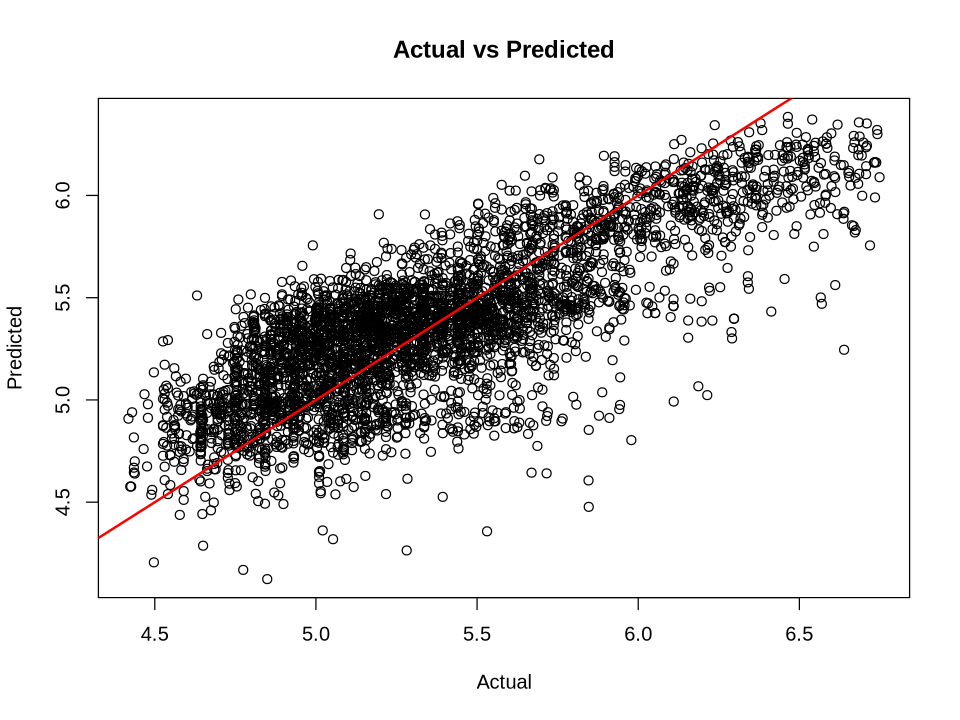

In [59]:
# Main developer: Alizah

# Predicting listing prices (realSum) with our model 
predictions <- predict(model, testing_data)

rmse_model <- rmse(testing_data$realSum, predictions)
rmse_model

mae_model <- mean(abs(testing_data$realSum - predictions))
mae_model

plot(actuals, predictions, main = "Actual vs Predicted", xlab = "Actual", ylab = "Predicted")
abline(a = 0, b = 1, col = "red", lwd = 2) 

In [68]:
metrics <- data.frame(
    metric = c("Baseline RMSE", "Baseline MAE", "Model RMSE", "Model MAE"),
    log_value = c(rmse_baseline, mae_baseline, rmse_model, mae_model),
    value = 1
)

metrics <- metrics %>%
            mutate(value = exp(log_value))

metrics

metric,log_value,value
<chr>,<dbl>,<dbl>
Baseline RMSE,0.4783533,1.613415
Baseline MAE,0.3842463,1.468507
Model RMSE,0.2949037,1.342997
Model MAE,0.2335149,1.263032


# 3) Discussion

In this section, you’ll interpret the results you obtained in the previous section with respect to the main question/goal of your project.

    Summarize what you found and the implications/impact of your findings.
    If relevant, discuss whether your results were what you expected to find.
    Discuss how your model could be improved;
    Discuss future questions/research this study could lead to.

We asked the question: 
> “Which factors are most useful for predicting the price of an Airbnb listing?”.

Through LASSO analysis, we found that the most statistically significance predictors are:
`a`
`b`
`c`,
Resulting in a model with an RMSE ~= `0.29`, which is better than the intercept-only model. 

[since it’s scaled, is it log? So I need to do e^(0.77^2)? Is it in Euros?]


Discuss Simpson's paradox (how overall observed associations may differ by city/season/other variables not considered)

### Possible improvements

Our analysis has many assumptions, and if any turn out to be false our results may be invalid or require further correction. For instance, the relationship between the predictors and realSum may not be strictly linear.

Since this is an external observational study, we cannot easily discover or isolate possible confounders from the data. 
There may also be hidden *interactions* or other important predictors that were overlooked or excluded from the dataset. For instance, the data used was collected over one summer, and thus does not consider the season. Other important variables could be the amenities, neighbourhood crime rate, and more. We note the risk of overfitting when including more predictors and interactive terms in a model.
In particular, only looking at the data for Rome, Budapest and London could result in *Simpson’s paradox*, where the apparent associations for these three cities are not observed in other cities, or as a whole in Europe. These factors may result in higher or lower model performance. 


Future studies could examine the long-term trends in Airbnb price with Time Series analyses, consider more variables and interactions such as the season. It may also be a good idea to analyze on a per-city basis, as well as the trends for different groups of cities, or the trends for other continents and countries.


# 4) References

- Toader, Victor, et al. "Analysis of Price Determinants in the Case of Airbnb Listings." Economic Research-Ekonomska Istraživanja, vol. 35, no. 1, 2021, pp. 2493–2509. https://doi.org/10.1080/1331677x.2021.1962380.

- Gyódi, Karol, and Łukasz Nawaro. "Determinants of Airbnb Prices in European Cities: A Spatial Econometrics Approach." Tourism Management, vol. 86, 2021, https://doi.org/10.1016/j.tourman.2021.104319.

- Gyódi, Karol, and Łukasz Nawaro. "Airbnb Prices in European Cities." Kaggle, 10 Mar. 2024, www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities/data.

